In [ ]:
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


drive.mount('/content/drive', force_remount=True)

folder_path = ''

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        df_name = filename.split('_')[0] + '_df'  # Extract the name before the underscore
        csv_file_path = os.path.join(folder_path, filename)
        try:
            globals()[df_name] = pd.read_csv(csv_file_path)  # Create a dataframe with the extracted name
            print(f"DataFrame '{df_name}' created from '{filename}'")
        except Exception as e:
            print(f"Error reading '{filename}': {e}")



Mounted at /content/drive
DataFrame 'demographic_df' created from 'demographic_202501292047.csv'
DataFrame 'evaluation_df' created from 'evaluation_202501292047.csv'
DataFrame 'explanation_df' created from 'explanation_202501292047.csv'
DataFrame 'perception_df' created from 'perception_202501292047.csv'
DataFrame 'personality_df' created from 'personality_202501292047.csv'
DataFrame 'preference_df' created from 'preference_202501292047.csv'
DataFrame 'preferred_df' created from 'preferred_202501292047.csv'
DataFrame 'profile_df' created from 'profile_202501292047.csv'
DataFrame 'recommendation_df' created from 'recommendation_202501292047.csv'
DataFrame 'user_df' created from 'user_202501292047.csv'
DataFrame 'listen_df' created from 'listen_202501292047.csv'
DataFrame 'analysis_df' created from 'analysis_202501292047.csv'


In [ ]:
analysis_df = analysis_df.reset_index(drop=True)
analysis_df = analysis_df[analysis_df['check'] == 3]
analysis_df.columns = analysis_df.columns.str.lower()
len(analysis_df)
analysis_df

,experiment_duration,user_id,enthusiast,age,gender,education,region,openness,conscientiousness,extroversion,...,taste_extroversion,taste_neuroticism,taste_openness,taste_featurebased,listen_agreeableness,listen_conscientiousness,listen_extroversion,listen_neuroticism,listen_openness,listen_featurebased
0,0:15:15,68,3,3,1,6,4,3.50,3.75,3.50,...,4,4,4,4,4,4,4,4,4,4
1,0:10:11,69,5,4,1,4,4,4.25,3.00,4.25,...,4,3,5,5,5,3,4,3,5,5
2,0:22:20,70,4,4,1,6,5,3.25,3.50,2.25,...,3,3,2,3,4,3,4,4,1,2
3,0:07:40,71,5,2,1,2,5,4.75,3.00,3.50,...,4,4,4,4,3,4,4,4,4,4
4,0:10:08,73,4,4,1,4,2,4.00,4.00,3.75,...,5,4,5,5,4,5,5,4,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,0:13:02,790,4,3,1,3,5,4.25,4.25,3.50,...,4,5,4,3,4,3,4,5,4,3
376,0:27:14,791,4,7,1,6,4,4.25,4.00,3.50,...,3,5,2,4,2,4,3,5,2,4
377,0:11:16,792,5,1,1,3,2,5.00,3.00,2.00,...,5,3,4,5,5,4,5,3,4,5
378,0:14:58,799,2,2,1,2,5,4.00,3.50,1.75,...,4,3,4,3,2,4,4,3,4,3



=== MEAN TABLE (DESCRIPTIVE) ===

                        N
explanation_type_norm    
openness               48
conscientiousness      31
extroversion           53
agreeableness          58
neuroticism            72
featurebased           86

Explanation-level perception
                       Confidence  Usefulness  Persuasiveness  Transparency  Comprehensibility
explanation_type_norm                                                                         
openness                    4.417       4.167           4.104         4.062              4.021
conscientiousness           4.161       4.129           3.806         4.194              4.032
extroversion                4.377       3.906           3.830         3.623              3.906
agreeableness               4.224       4.155           4.034         3.983              4.034
neuroticism                 4.444       4.292           4.153         4.125              4.139
featurebased                4.291       4.023           3.849 

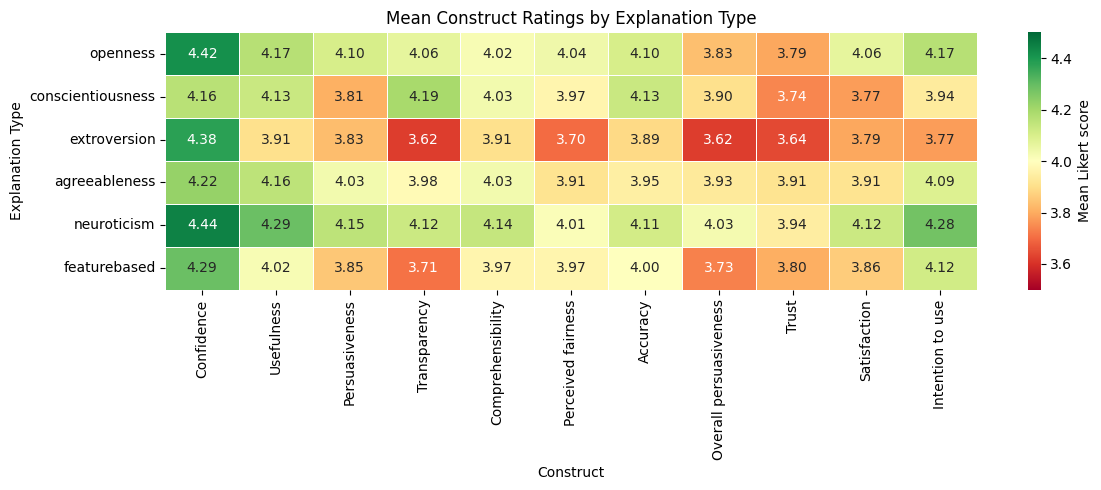

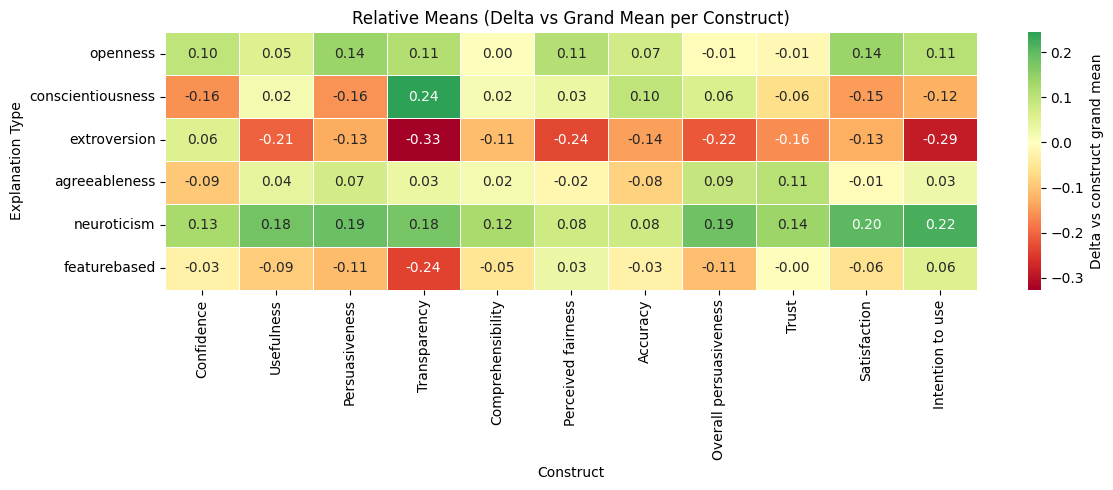

In [23]:
import re
from itertools import combinations
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns


GOAL_META = {
    "usefulness": ("Usefulness", "Explanation-level perception"),
    "persuasion": ("Persuasiveness", "Explanation-level perception"),
    "transparency": ("Transparency", "Explanation-level perception"),
    "comprehensibility": ("Comprehensibility", "Explanation-level perception"),
    "fairness": ("Perceived fairness", "System-level perception"),
    "accuracy": ("Accuracy", "System-level perception"),
    "compelling": ("Overall persuasiveness", "System-level perception"),
    "trustworthy": ("Trust", "System-level perception"),
    "satisfaction": ("Satisfaction", "System-level perception"),
    "system": ("Intention to use", "System-level perception"),
    "confidence": ("Confidence", "Explanation-level perception"),
}

GROUP_ORDER = ["Explanation-level perception", "System-level perception"]


def normalize_expl_type(value) -> str:
    if pd.isna(value):
        return ""
    s = re.sub(r"[^a-z]", "", str(value).strip().lower())
    mapping = {
        "feature": "featurebased",
        "featurebased": "featurebased",
        "features": "featurebased",
        "openness": "openness",
        "open": "openness",
        "o": "openness",
        "conscientiousness": "conscientiousness",
        "cons": "conscientiousness",
        "c": "conscientiousness",
        "extraversion": "extroversion",
        "extroversion": "extroversion",
        "extra": "extroversion",
        "e": "extroversion",
        "agreeableness": "agreeableness",
        "agree": "agreeableness",
        "a": "agreeableness",
        "neuroticism": "neuroticism",
        "neuro": "neuroticism",
        "n": "neuroticism",
    }
    return mapping.get(s, s)


def goal_label(goal_key: str) -> Tuple[str, str]:
    return GOAL_META.get(goal_key, (goal_key, "Other"))


def print_grouped_table(df: pd.DataFrame, title: str, label_col: str) -> None:
    print(f"\n=== {title} ===\n")
    if df.empty:
        print("No results to display.")
        return

    df2 = df.copy()
    df2["Construct"] = df2[label_col].apply(lambda x: goal_label(str(x))[0])
    df2["Group"] = df2[label_col].apply(lambda x: goal_label(str(x))[1])

    for grp in GROUP_ORDER + sorted([g for g in df2["Group"].unique() if g not in GROUP_ORDER]):
        sub = df2[df2["Group"] == grp]
        if sub.empty:
            continue
        print(f"\n{grp}")
        cols = [c for c in sub.columns if c not in {"Group", label_col}]
        print(sub[cols].to_string(index=False))


def kw_posthoc(df: pd.DataFrame, goal: str, styles_used: List[str], min_n: int) -> pd.DataFrame:
    rows = []
    for a, b in combinations(styles_used, 2):
        x = df.loc[df["explanation_type_norm"] == a, goal].dropna()
        y = df.loc[df["explanation_type_norm"] == b, goal].dropna()
        if len(x) < min_n or len(y) < min_n:
            continue
        _, p = mannwhitneyu(x, y, alternative="two-sided")
        rows.append((goal, f"{a} vs {b}", float(p)))

    if not rows:
        return pd.DataFrame()

    goals_, comps, pvals = zip(*rows)
    reject, p_adj, _, _ = multipletests(pvals, method="holm")

    return (
        pd.DataFrame(
            {
                "goal": goals_,
                "comparison": comps,
                "p_raw": pvals,
                "p_holm": p_adj,
                "significant": reject,
            }
        )
        .sort_values("p_holm")
        .reset_index(drop=True)
    )


styles = [
    "openness",
    "conscientiousness",
    "extroversion",
    "agreeableness",
    "neuroticism",
    "featurebased",
]

goals_requested = [
    "confidence",
    "usefulness",
    "persuasion",
    "transparency",
    "comprehensibility",
    "fairness",
    "accuracy",
    "compelling",
    "trustworthy",
    "satisfaction",
    "system",
]

MIN_N_PER_GROUP = 5

df = analysis_df.copy()
df["explanation_type_norm"] = df["explanation type"].apply(normalize_expl_type)
df = df[df["explanation_type_norm"].isin(styles)].copy()

if "compelling" not in df.columns and "compeling" in df.columns:
    df["compelling"] = df["compeling"]

available_goals = [g for g in goals_requested if g in df.columns]

if not available_goals:
    raise ValueError("None of the requested goal columns exist in analysis_df.")

for g in available_goals:
    df[g] = pd.to_numeric(df[g], errors="coerce").clip(1, 5)

n_per_group = (
    df.groupby("explanation_type_norm")
    .size()
    .reindex(styles)
    .fillna(0)
    .astype(int)
)

mean_table = (
    df.groupby("explanation_type_norm")[available_goals]
    .mean()
    .reindex(styles)
)

mean_table.insert(0, "N", n_per_group)

print("\n=== MEAN TABLE (DESCRIPTIVE) ===\n")
print(mean_table[["N"]].to_string())

grouped_cols: Dict[str, List[Tuple[str, str]]] = {g: [] for g in GROUP_ORDER}
grouped_cols["Other"] = []

for g in available_goals:
    lab, grp = goal_label(g)
    grouped_cols.setdefault(grp, []).append((g, lab))

for grp in GROUP_ORDER + [k for k in grouped_cols.keys() if k not in GROUP_ORDER and k != "Other"]:
    pairs = grouped_cols.get(grp, [])
    if not pairs:
        continue
    cols = [orig for orig, _ in pairs]
    ren = {orig: lab for orig, lab in pairs}
    print(f"\n{grp}")
    print(mean_table[cols].rename(columns=ren).round(3).to_string())

if grouped_cols.get("Other"):
    cols = [orig for orig, _ in grouped_cols["Other"]]
    ren = {orig: lab for orig, lab in grouped_cols["Other"]}
    print("\nOther")
    print(mean_table[cols].rename(columns=ren).round(3).to_string())

overall_mean_per_goal = mean_table[available_goals].mean(axis=0)
mean_delta = mean_table[available_goals].subtract(overall_mean_per_goal, axis=1)
mean_pct = (mean_table[available_goals].divide(overall_mean_per_goal, axis=1) - 1.0) * 100

print("\n=== RELATIVE MEANS (DELTA VS GRAND MEAN PER GOAL) ===\n")
print(mean_delta.round(3).to_string())

kw_rows = []
groups_cache = {}

for g in available_goals:
    groups = {}
    for s in styles:
        vals = df.loc[df["explanation_type_norm"] == s, g].dropna().values
        if len(vals) >= MIN_N_PER_GROUP:
            groups[s] = vals
    if len(groups) < 2:
        continue
    h_stat, p_val = kruskal(*groups.values())
    kw_rows.append(
        {
            "goal": g,
            "H": float(h_stat),
            "p": float(p_val),
            "N_total": int(sum(len(v) for v in groups.values())),
            "k_groups": int(len(groups)),
        }
    )
    groups_cache[g] = list(groups.keys())

kw_df = pd.DataFrame(kw_rows).sort_values("p").reset_index(drop=True)
print_grouped_table(kw_df.round(4), "KRUSKAL--WALLIS RESULTS", "goal")

posthoc_tables = []
for _, row in kw_df.iterrows():
    if float(row["p"]) <= 0.05:
        ph = kw_posthoc(df, str(row["goal"]), groups_cache.get(str(row["goal"]), []), MIN_N_PER_GROUP)
        if not ph.empty:
            posthoc_tables.append(ph)

if posthoc_tables:
    posthoc_df = pd.concat(posthoc_tables, ignore_index=True)
    posthoc_df_display = posthoc_df.copy()
    posthoc_df_display["goal"] = posthoc_df_display["goal"].apply(lambda x: goal_label(str(x))[0])
    posthoc_df_display = posthoc_df_display.rename(columns={"goal": "Construct"})
    print("\n=== POST-HOC RESULTS (HOLM-CORRECTED) ===\n")
    print(posthoc_df_display.round(4).sort_values(["Construct", "p_holm"]).to_string(index=False))
else:
    print("\nNo post-hoc tests triggered (no p <= .05).")

mean_table_plot = mean_table[available_goals].copy()
mean_table_plot = mean_table_plot.rename(columns={g: goal_label(g)[0] for g in available_goals})

plt.figure(figsize=(12, 5))
sns.heatmap(
    mean_table_plot,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    vmin=3.5,
    vmax=4.5,
    cbar_kws={"label": "Mean Likert score"},
    linewidths=0.5,
    linecolor="white",
)
plt.title("Mean Construct Ratings by Explanation Type")
plt.ylabel("Explanation Type")
plt.xlabel("Construct")
plt.tight_layout()
plt.show()

mean_delta_plot = mean_delta.rename(columns={g: goal_label(g)[0] for g in available_goals})
plt.figure(figsize=(12, 5))
sns.heatmap(
    mean_delta_plot,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0,
    cbar_kws={"label": "Delta vs construct grand mean"},
    linewidths=0.5,
    linecolor="white",
)
plt.title("Relative Means (Delta vs Grand Mean per Construct)")
plt.ylabel("Explanation Type")
plt.xlabel("Construct")
plt.tight_layout()
plt.show()
